In [1]:
import pandas as pd
import random

from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns

random.seed(10)

# Data Setup

Datasets:
* Audit Rates by County from ProPublica 
* Tax Return Data by County from IRS 
* Demographic Data by County from Kaggle


## Audit Rates

* Audit rates (per 1000 returns) gathered by ProPublica
* https://github.com/propublica/auditData

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/propublica/auditData/master/data/cleaned/auditsData_2019.04.03.csv')

In [3]:
df

,fips,name,state,Number_of_returns,estimated_exams,audit_rate,audit_rate_trunk
0,1001,"Autauga County, Alabama",Alabama,95170.0,721.0,7.575917,7.575917
1,1003,"Baldwin County, Alabama",Alabama,362490.0,2833.0,7.815388,7.815388
2,1005,"Barbour County, Alabama",Alabama,39440.0,360.0,9.127789,9.127789
3,1007,"Bibb County, Alabama",Alabama,31840.0,260.0,8.165829,8.165829
4,1009,"Blount County, Alabama",Alabama,87970.0,673.0,7.650335,7.650335
...,...,...,...,...,...,...,...
3136,56037,"Sweetwater County, Wyoming",Wyoming,84960.0,578.0,6.803202,6.803202
3137,56039,"Teton County, Wyoming",Wyoming,57890.0,447.0,7.721541,7.721541
3138,56041,"Uinta County, Wyoming",Wyoming,37540.0,266.0,7.085775,7.085775
3139,56043,"Washakie County, Wyoming",Wyoming,15830.0,110.0,6.948831,6.948831


In [4]:
df[df['audit_rate'] != df['audit_rate_trunk']]
# audit rate trunk - floor of 6 for visualization purposes
# only 63 counties - outliers

,fips,name,state,Number_of_returns,estimated_exams,audit_rate,audit_rate_trunk
67,2013,"Aleutians East Borough, Alaska",Alaska,3960.0,23.0,5.808081,6.0
71,2060,"Bristol Bay Borough, Alaska",Alaska,2140.0,7.0,3.271028,6.0
72,2068,"Denali Borough, Alaska",Alaska,4620.0,26.0,5.627706,6.0
89,2230,"Skagway Municipality, Alaska",Alaska,3050.0,18.0,5.901639,6.0
94,2282,"Yakutat City and Borough, Alaska",Alaska,1160.0,3.0,2.586207,6.0
...,...,...,...,...,...,...,...
2718,48393,"Roberts County, Texas",Texas,1600.0,6.0,3.750000,6.0
2737,48431,"Sterling County, Texas",Texas,2360.0,10.0,4.237288,6.0
2743,48443,"Terrell County, Texas",Texas,1550.0,6.0,3.870968,6.0
2780,49009,"Daggett County, Utah",Utah,1710.0,4.0,2.339181,6.0


In [5]:
# splitting 'fips' code into state and county columns for matching purposes
df['st_code'] = df['fips'].astype('str').str[:-3].astype('int')
df['cty_code'] = df['fips'].astype('str').str[-3:].astype('int')

## Income

Demographic Data by County from Kaggle:

https://www.kaggle.com/muonneutrino/us-census-demographic-data

In [7]:
# dfi = pd.read_csv('https://raw.githubusercontent.com/Roozbeh-jafari/840.Data-Ethics-US-Taxpayers-Algorithms/main/DataSets/acs2015_county_data.csv?token=APRKZUFFBDGAQVHKEIJZHFTAVKRHK' )
# dfi = pd.read_csv('acs2015_county_data.csv')
dfi = pd.read_csv('/content/acs2015_county_data.csv')
# dfi = pd.read_csv('../Datasets/acs2015_county_data.csv')

In [8]:
dfi

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,1.0,0.0,40725,51281.0,2391.0,24974,1080,12.9,18.6,33.2,17.0,24.2,8.6,17.1,87.5,8.8,0.1,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,0.7,0.0,147695,50254.0,1263.0,27317,711,13.4,19.2,33.1,17.7,27.1,10.8,11.2,84.7,8.8,0.1,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,0.4,0.0,20714,32964.0,2973.0,16824,798,26.7,45.3,26.8,16.1,23.1,10.8,23.1,83.8,10.9,0.4,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,0.1,0.0,17495,38678.0,3995.0,18431,1618,16.8,27.9,21.5,17.9,17.8,19.0,23.7,83.2,13.5,0.5,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,0.1,0.0,42345,45813.0,3141.0,20532,708,16.7,27.2,28.5,14.1,23.9,13.5,19.9,84.9,11.2,0.4,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,72145,Puerto Rico,Vega Baja,56858,27379,29479,96.4,3.4,0.1,0.0,0.0,0.0,43656,16948.0,1234.0,9102,538,48.5,56.1,30.1,21.6,24.7,9.2,14.3,89.1,7.1,0.9,1.2,1.3,0.3,32.0,13660,78.3,17.6,4.1,0.0,15.2
3216,72147,Puerto Rico,Vieques,9130,4585,4545,96.7,2.9,0.0,0.0,0.0,0.0,7085,18104.0,3771.0,8821,939,39.1,58.1,18.4,38.2,18.5,15.7,9.1,69.1,17.8,1.0,10.8,0.0,1.4,14.0,2860,44.5,41.6,13.6,0.3,12.2
3217,72149,Puerto Rico,Villalba,24685,12086,12599,99.7,0.0,0.0,0.0,0.0,0.0,18458,17818.0,1255.0,8420,486,54.0,68.3,23.6,21.0,21.8,13.9,19.7,82.0,11.4,0.1,3.2,0.0,3.3,26.9,6795,59.2,27.5,13.1,0.2,25.9
3218,72151,Puerto Rico,Yabucoa,36279,17648,18631,99.8,0.2,0.0,0.0,0.1,0.0,27924,15627.0,1836.0,7960,512,52.3,62.1,25.9,25.9,20.7,12.8,14.7,86.0,7.9,0.0,2.3,2.3,1.5,29.5,8083,65.1,27.6,7.3,0.0,24.3


## Tax Return

Tax return data by US county

https://www.irs.gov/statistics/compliance-presence

In [10]:
# dft = pd.read_csv('https://raw.githubusercontent.com/Roozbeh-jafari/840.Data-Ethics-US-Taxpayers-Algorithms/main/DataSets/tax-return-2015.csv?token=APRKZUBW7TZ3AFQU3H6WBZLAVKRJO')
# dft = pd.read_csv('tax-return-2015.csv')
dft = pd.read_csv('/content/tax-return-2015.csv')
# dft = pd.read_csv('../Datasets/tax-return-2015.csv')
dft

,State FIPS code [1],State,County FIPS code [1],County name,Number of returns,Number of single returns,Number of joint returns,Number of head of household returns,Number with paid preparer's signature,Number of exemptions,Number of dependents,Number of volunteer prepared returns [2],Number of volunteer income tax assistance (VITA) prepared returns,Number of tax counseling for the elderly (TCE) prepared returns,Number of volunteer prepared \nreturns with\nEarned Income Credit,Number of refund anticipation loan returns,Number of refund anticipation check returns,Number of elderly returns [3],Adjusted gross income (AGI) [4],Total income num,Total income amt,Salaries and wages in AGI num,Salaries and wages in AGI amt,Taxable interest num,Taxable interest amt,Ordinary dividends num,Ordinary dividends amt,Qualified dividends [5] num,Qualified dividends [5] amt,State and local income tax refunds\n num,State and local income tax refunds\n amt,Business or profession\nnet income (less loss) num,Business or profession\nnet income (less loss) amt,Net capital gain (less loss) in AGI num,Net capital gain (less loss) in AGI amt,Taxable individual retirement\narrangement distributions num,Taxable individual retirement\narrangement distributions amt,Pensions and annuities in AGI num,Pensions and annuities in AGI amt,Number of \nfarm returns num,...,Nonrefundable education credit num,Nonrefundable education credit amt,Retirement savings contribution credit num,Retirement savings contribution credit amt,Child tax credit num,Child tax credit amt,Residential energy tax credit num,Residential energy tax credit amt,Self-employment tax num,Self-employment tax amt,Total premium tax credit num,Total premium tax credit amt,Advance premium tax credit num,Advance premium tax credit amt,Health care individual responsibility payment num,Health care individual responsibility payment amt,Total tax payments num,Total tax payments amt,Earned income credit [7] num,Earned income credit [7] amt,Excess earned income credit \n(refundable) [8] num,Excess earned income credit \n(refundable) [8] amt,Additional child tax credit num,Additional child tax credit amt,Refundable education credit num,Refundable education credit amt,Net premium tax credit num,Net premium tax credit amt,Income tax [9] num,Income tax [9] amt,Total tax liability [10] num,Total tax liability [10] amt,Additional Medicare tax num,Additional Medicare tax amt,Net investment income tax num,Net investment income tax amt,Tax due at time of filing [11] num,Tax due at time of filing [11] amt,Overpayments refunded [12] num,Overpayments refunded [12] amt
0,0,US,0,Total [13],148965910,70209250,53923170,21890640,80046180,289089330,95564540,3549610,1855800,1693980,526520,457940,21365980,34715360,10074264203,148463360,10223004480,123272570,7008525735,42221420,89362337,27438590,246436572,25603510,191255367,20154420,30623936,24704120,335562990,24187930,667720309,13973180,249199152,27891270,680105287,1853030,...,9671340,10242220,7969270,1395349,22262740,26867439,2594560,2128417,19385880,59225710,5166550,18878404,5836460,20882039,6653270,3064758,140778140,1766105893,27972300,68008777,23959360,58451691,19400100,26045489,9635000,8567079,2403200,1596320,102005440,1432106443,112137600,1522112987,3475390,7607693,3781620,21033338,28883270,159391261,112176640,350257176
1,1,AL,0,Alabama,2053620,834300,763210,415730,1172420,4166050,1467040,45570,28830,16760,7720,15400,457080,477210,111789331,2046690,113236900,1710150,80323944,502130,763242,268410,1724024,246330,1351071,318950,340193,345310,3128573,228700,4203762,171570,2797936,421830,10091228,45200,...,145900,154923,122430,22009,331830,386740,39130,19239,251070,638724,79620,275503,86890,295407,70350,29736,1960840,17604731,521420,1444531,467990,1279982,360840,481943,173090,163859,39440,21778,1303380,13179616,1458720,14075850,24800,43315,30150,111100,361940,1717754,1607070,4845454
2,1,AL,1,Autauga County,23960,9130,10020,4290,10960,50220,17800,510,130,370,0,70,5150,5160,129101

In [11]:
# adding ratio columns
dft['volunteer_preparer_percentage'] = dft['Number of volunteer prepared returns [2]'] / dft['Number of returns']
dft['paid_preparer_percentage'] = dft['Number with paid preparer\'s signature'] / dft['Number of returns']
dft['wage_income_percentage'] = dft['Salaries and wages in AGI num'] / dft['Number of returns']
dft['dividends_percentage'] = dft['Qualified dividends [5] num'] / dft['Number of returns']
dft['cap_gain_percentage'] =  dft['Net capital gain (less loss) in AGI num'] / dft['Number of returns']
dft['eic_percentage'] =  dft['Earned income credit [7] num'] / dft['Number of returns']

In [12]:
dft[dft['Number of returns'] > 10000].sort_values('dividends_percentage', ascending = False)

# counties w. > 10,000 returns sorted by percentage of returns with divend income (wealthy populations)

,State FIPS code [1],State,County FIPS code [1],County name,Number of returns,Number of single returns,Number of joint returns,Number of head of household returns,Number with paid preparer's signature,Number of exemptions,Number of dependents,Number of volunteer prepared returns [2],Number of volunteer income tax assistance (VITA) prepared returns,Number of tax counseling for the elderly (TCE) prepared returns,Number of volunteer prepared \nreturns with\nEarned Income Credit,Number of refund anticipation loan returns,Number of refund anticipation check returns,Number of elderly returns [3],Adjusted gross income (AGI) [4],Total income num,Total income amt,Salaries and wages in AGI num,Salaries and wages in AGI amt,Taxable interest num,Taxable interest amt,Ordinary dividends num,Ordinary dividends amt,Qualified dividends [5] num,Qualified dividends [5] amt,State and local income tax refunds\n num,State and local income tax refunds\n amt,Business or profession\nnet income (less loss) num,Business or profession\nnet income (less loss) amt,Net capital gain (less loss) in AGI num,Net capital gain (less loss) in AGI amt,Taxable individual retirement\narrangement distributions num,Taxable individual retirement\narrangement distributions amt,Pensions and annuities in AGI num,Pensions and annuities in AGI amt,Number of \nfarm returns num,...,Residential energy tax credit num,Residential energy tax credit amt,Self-employment tax num,Self-employment tax amt,Total premium tax credit num,Total premium tax credit amt,Advance premium tax credit num,Advance premium tax credit amt,Health care individual responsibility payment num,Health care individual responsibility payment amt,Total tax payments num,Total tax payments amt,Earned income credit [7] num,Earned income credit [7] amt,Excess earned income credit \n(refundable) [8] num,Excess earned income credit \n(refundable) [8] amt,Additional child tax credit num,Additional child tax credit amt,Refundable education credit num,Refundable education credit amt,Net premium tax credit num,Net premium tax credit amt,Income tax [9] num,Income tax [9] amt,Total tax liability [10] num,Total tax liability [10] amt,Additional Medicare tax num,Additional Medicare tax amt,Net investment income tax num,Net investment income tax amt,Tax due at time of filing [11] num,Tax due at time of filing [11] amt,Overpayments refunded [12] num,Overpayments refunded [12] amt,volunteer_preparer_percentage,paid_preparer_percentage,wage_income_percentage,dividends_percentage,cap_gain_percentage,eic_percentage
1813,34,NJ,19,Hunterdon County,64620,29980,29410,4120,39990,122900,35850,1200,1060,130,220,0,3050,18680,7689706,64490,7835302,52340,5435316,29620,50326,26940,210596,25660,162584,17180,34002,11680,305709,22440,439415,9610,217142,14340,411313,1410,...,1830,1454,10060,50492,1580,7605,1840,8551,1620,894,60710,1495165,3440,5491,2510,4287,2010,2475,3310,3265,760,864,51350,1358257,53730,1435113,5920,11773,5370,12796,17050,137075,42330,146439,0.018570,0.618849,0.809966,0.397091,0.347261,0.053234
389,12,FL,119,Sumter County,55010,20100,30600,3460,27050,97130,12340,6720,50,6670,0,30,3960,39270,4047803,54790,4097430,24610,969323,28690,69477,23290,191614,21790,140086,2320,4092,5980,64339,21050,309635,22910,504241,32140,1079604,640,...,1560,678,4510,11235,1960,9065,2240,10206,1310,646,49550,685964,5430,13000,4660,11362,3290,4564,940,813,810,600,40740,581465,42790,601857,350,672,1180,7398,14510,69364,34260,132747,0.122160,0.491729,0.447373,0.396110,0.382658,0.098709
212,6,CA,41,Marin County,132580,67110,51990,11250,85400,245630,69200,2670,760,1920,240,0,5650,45950,22455167,132120,23006100,92480,11778965,63780,273964,55050,1174705,52350,923269,29000,127648,37640,1435995,53720,3891232,21460,626341,25110,864938,370,...,2000,4797,33410,212290,5680,30083,6890,34803,3420,2033,119520,5220628,9000,14985,6010,10473,6620,8423,3920,3160,3010,3142,102240,4651959,111170,5007282,14360,45073,16270,136967,44780,502657,68740,430535,0.020139,0.644139,0

## Merge

In [14]:
# merging demographic with audit rates
dfmm = df.merge(dfi, how = 'left', left_on='fips', right_on='CensusId').dropna()
dfmm.head()

# dfmm.to_csv('audit-demographics-merged.csv', index = False)
# to save to csv

,fips,name,state,Number_of_returns,estimated_exams,audit_rate,audit_rate_trunk,st_code,cty_code,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,"Autauga County, Alabama",Alabama,95170.0,721.0,7.575917,7.575917,1,1,1001.0,Alabama,Autauga,55221.0,26745.0,28476.0,2.6,75.8,18.5,0.4,1.0,0.0,40725.0,51281.0,2391.0,24974.0,1080.0,12.9,18.6,33.2,17.0,24.2,8.6,17.1,87.5,8.8,0.1,0.5,1.3,1.8,26.5,23986.0,73.6,20.9,5.5,0.0,7.6
1,1003,"Baldwin County, Alabama",Alabama,362490.0,2833.0,7.815388,7.815388,1,3,1003.0,Alabama,Baldwin,195121.0,95314.0,99807.0,4.5,83.1,9.5,0.6,0.7,0.0,147695.0,50254.0,1263.0,27317.0,711.0,13.4,19.2,33.1,17.7,27.1,10.8,11.2,84.7,8.8,0.1,1.0,1.4,3.9,26.4,85953.0,81.5,12.3,5.8,0.4,7.5
2,1005,"Barbour County, Alabama",Alabama,39440.0,360.0,9.127789,9.127789,1,5,1005.0,Alabama,Barbour,26932.0,14497.0,12435.0,4.6,46.2,46.7,0.2,0.4,0.0,20714.0,32964.0,2973.0,16824.0,798.0,26.7,45.3,26.8,16.1,23.1,10.8,23.1,83.8,10.9,0.4,1.8,1.5,1.6,24.1,8597.0,71.8,20.8,7.3,0.1,17.6
3,1007,"Bibb County, Alabama",Alabama,31840.0,260.0,8.165829,8.165829,1,7,1007.0,Alabama,Bibb,22604.0,12073.0,10531.0,2.2,74.5,21.4,0.4,0.1,0.0,17495.0,38678.0,3995.0,18431.0,1618.0,16.8,27.9,21.5,17.9,17.8,19.0,23.7,83.2,13.5,0.5,0.6,1.5,0.7,28.8,8294.0,76.8,16.1,6.7,0.4,8.3
4,1009,"Blount County, Alabama",Alabama,87970.0,673.0,7.650335,7.650335,1,9,1009.0,Alabama,Blount,57710.0,28512.0,29198.0,8.6,87.9,1.5,0.3,0.1,0.0,42345.0,45813.0,3141.0,20532.0,708.0,16.7,27.2,28.5,14.1,23.9,13.5,19.9,84.9,11.2,0.4,0.9,0.4,2.3,34.9,22189.0,82.0,13.5,4.2,0.4,7.7


In [16]:
# merging tax return with audit rates
dftm = dft.merge(df, how = 'left',left_on = ['State FIPS code [1]', 'County FIPS code [1]'], right_on= ['st_code', 'cty_code'])
dftm.head()

# dftm.to_csv('tax-return-merged.csv', index= False)   # saving to csv

,State FIPS code [1],State,County FIPS code [1],County name,Number of returns,Number of single returns,Number of joint returns,Number of head of household returns,Number with paid preparer's signature,Number of exemptions,Number of dependents,Number of volunteer prepared returns [2],Number of volunteer income tax assistance (VITA) prepared returns,Number of tax counseling for the elderly (TCE) prepared returns,Number of volunteer prepared \nreturns with\nEarned Income Credit,Number of refund anticipation loan returns,Number of refund anticipation check returns,Number of elderly returns [3],Adjusted gross income (AGI) [4],Total income num,Total income amt,Salaries and wages in AGI num,Salaries and wages in AGI amt,Taxable interest num,Taxable interest amt,Ordinary dividends num,Ordinary dividends amt,Qualified dividends [5] num,Qualified dividends [5] amt,State and local income tax refunds\n num,State and local income tax refunds\n amt,Business or profession\nnet income (less loss) num,Business or profession\nnet income (less loss) amt,Net capital gain (less loss) in AGI num,Net capital gain (less loss) in AGI amt,Taxable individual retirement\narrangement distributions num,Taxable individual retirement\narrangement distributions amt,Pensions and annuities in AGI num,Pensions and annuities in AGI amt,Number of \nfarm returns num,...,Health care individual responsibility payment amt,Total tax payments num,Total tax payments amt,Earned income credit [7] num,Earned income credit [7] amt,Excess earned income credit \n(refundable) [8] num,Excess earned income credit \n(refundable) [8] amt,Additional child tax credit num,Additional child tax credit amt,Refundable education credit num,Refundable education credit amt,Net premium tax credit num,Net premium tax credit amt,Income tax [9] num,Income tax [9] amt,Total tax liability [10] num,Total tax liability [10] amt,Additional Medicare tax num,Additional Medicare tax amt,Net investment income tax num,Net investment income tax amt,Tax due at time of filing [11] num,Tax due at time of filing [11] amt,Overpayments refunded [12] num,Overpayments refunded [12] amt,volunteer_preparer_percentage,paid_preparer_percentage,wage_income_percentage,dividends_percentage,cap_gain_percentage,eic_percentage,fips,name,state,Number_of_returns,estimated_exams,audit_rate,audit_rate_trunk,st_code,cty_code
0,0,US,0,Total [13],148965910,70209250,53923170,21890640,80046180,289089330,95564540,3549610,1855800,1693980,526520,457940,21365980,34715360,10074264203,148463360,10223004480,123272570,7008525735,42221420,89362337,27438590,246436572,25603510,191255367,20154420,30623936,24704120,335562990,24187930,667720309,13973180,249199152,27891270,680105287,1853030,...,3064758,140778140,1766105893,27972300,68008777,23959360,58451691,19400100,26045489,9635000,8567079,2403200,1596320,102005440,1432106443,112137600,1522112987,3475390,7607693,3781620,21033338,28883270,159391261,112176640,350257176,0.023828,0.537346,0.827522,0.171875,0.162372,0.187777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,AL,0,Alabama,2053620,834300,763210,415730,1172420,4166050,1467040,45570,28830,16760,7720,15400,457080,477210,111789331,2046690,113236900,1710150,80323944,502130,763242,268410,1724024,246330,1351071,318950,340193,345310,3128573,228700,4203762,171570,2797936,421830,10091228,45200,...,29736,1960840,17604731,521420,1444531,467990,1279982,360840,481943,173090,163859,39440,21778,1303380,13179616,1458720,14075850,24800,43315,30150,111100,361940,1717754,1607070,4845454,0.022190,0.570904,0.832749,0.119949,0.111364,0.253903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,AL,1,Autauga County,23960,9130,10020,4290,10960,50220,17800,510,130,370,0,70,5150,5160,1291011,23880,1304385,20360,979232,7210,5850,3030,9391,2740,7109,3770,3235,3490,28135,2520,17134,1930,25374,5520,147466,380,...,323,23120,175903,5240,14098,4650,12521,3630,4716,1870,1743,390,195,16400,126990,17800,135207,120,115,170,387,4310,14233,18910,53521,0.021285,0.457429,0.849750,0.114357,0.105175,0.

In [17]:
# merging demographic, tax return, and audit rates
# dataframe with all variables of interest

dfmt = df.merge(dfi, how = 'left', left_on='fips', right_on='CensusId')
dfma = dfmt.merge(dft, how = 'left', left_on =['st_code', 'cty_code'], right_on = ['State FIPS code [1]', 'County FIPS code [1]'] )
dfma.head()

# dfma.to_csv('../Datasets/merged-all.csv', index=False)

,fips,name,state,Number_of_returns,estimated_exams,audit_rate,audit_rate_trunk,st_code,cty_code,CensusId,State_x,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,...,Residential energy tax credit num,Residential energy tax credit amt,Self-employment tax num,Self-employment tax amt,Total premium tax credit num,Total premium tax credit amt,Advance premium tax credit num,Advance premium tax credit amt,Health care individual responsibility payment num,Health care individual responsibility payment amt,Total tax payments num,Total tax payments amt,Earned income credit [7] num,Earned income credit [7] amt,Excess earned income credit \n(refundable) [8] num,Excess earned income credit \n(refundable) [8] amt,Additional child tax credit num,Additional child tax credit amt,Refundable education credit num,Refundable education credit amt,Net premium tax credit num,Net premium tax credit amt,Income tax [9] num,Income tax [9] amt,Total tax liability [10] num,Total tax liability [10] amt,Additional Medicare tax num,Additional Medicare tax amt,Net investment income tax num,Net investment income tax amt,Tax due at time of filing [11] num,Tax due at time of filing [11] amt,Overpayments refunded [12] num,Overpayments refunded [12] amt,volunteer_preparer_percentage,paid_preparer_percentage,wage_income_percentage,dividends_percentage,cap_gain_percentage,eic_percentage
0,1001,"Autauga County, Alabama",Alabama,95170.0,721.0,7.575917,7.575917,1,1,1001.0,Alabama,Autauga,55221.0,26745.0,28476.0,2.6,75.8,18.5,0.4,1.0,0.0,40725.0,51281.0,2391.0,24974.0,1080.0,12.9,18.6,33.2,17.0,24.2,8.6,17.1,87.5,8.8,0.1,0.5,1.3,1.8,26.5,...,410.0,143.0,2550.0,6138.0,780.0,2376.0,840.0,2604.0,710.0,323.0,23120.0,175903.0,5240.0,14098.0,4650.0,12521.0,3630.0,4716.0,1870.0,1743.0,390.0,195.0,16400.0,126990.0,17800.0,135207.0,120.0,115.0,170.0,387.0,4310.0,14233.0,18910.0,53521.0,0.021285,0.457429,0.849750,0.114357,0.105175,0.218698
1,1003,"Baldwin County, Alabama",Alabama,362490.0,2833.0,7.815388,7.815388,1,3,1003.0,Alabama,Baldwin,195121.0,95314.0,99807.0,4.5,83.1,9.5,0.6,0.7,0.0,147695.0,50254.0,1263.0,27317.0,711.0,13.4,19.2,33.1,17.7,27.1,10.8,11.2,84.7,8.8,0.1,1.0,1.4,3.9,26.4,...,1410.0,798.0,13680.0,37978.0,4420.0,15978.0,4920.0,17275.0,3530.0,1644.0,86980.0,848360.0,17840.0,45725.0,15280.0,39092.0,12080.0,15810.0,5630.0,5139.0,2230.0,1481.0,62980.0,711964.0,69840.0,763095.0,1450.0,2138.0,1840.0,5128.0,21340.0,119349.0,65910.0,184209.0,0.018252,0.504295,0.775821,0.167490,0.169315,0.191540
2,1005,"Barbour County, Alabama",Alabama,39440.0,360.0,9.127789,9.127789,1,5,1005.0,Alabama,Barbour,26932.0,14497.0,12435.0,4.6,46.2,46.7,0.2,0.4,0.0,20714.0,32964.0,2973.0,16824.0,798.0,26.7,45.3,26.8,16.1,23.1,10.8,23.1,83.8,10.9,0.4,1.8,1.5,1.6,24.1,...,130.0,64.0,1260.0,2406.0,370.0,1252.0,390.0,1358.0,370.0,139.0,9100.0,54654.0,3360.0,9888.0,3080.0,8715.0,2430.0,3265.0,720.0,690.0,170.0,72.0,5110.0,32266.0,6130.0,35494.0,20.0,32.0,50.0,181.0,1340.0,4631.0,7830.0,24181.0,0.003128,0.687174,0.819604,0.099062,0.092805,0.350365
3,1007,"Bibb County, Alabama",Alabama,31840.0,260.0,8.165829,8.165829,1,7,1007.0,Alabama,Bibb,22604.0,12073.0,10531.0,2.2,74.5,21.4,0.4,0.1,0.0,17495.0,38678.0,3995.0,18431.0,1618.0,16.8,27.9,21.5,17.9,17.8,19.0,23.7,83.2,13.5,0.5,0.6,1.5,0.7,28.8,...,130.0,57.0,870.0,1709.0,270.0,984.0,290.0,1012.0,360.0,147.0,7640.0,50886.0,2270.0,6367.0,2060.0,5736.0,1540.0,2003.0,450.0,396.0,140.0,79.0,5050.0,38383.0,5600.0,40622.0,0.0,0.0,40.0,43.0,1180.0,6770.0,6560.0,19818.0,0.006281,0.586683,0.866834,0.055276,0.055276,0.285176
4,1009,"Blount County, Alabama",Alabama,87970.0,673.0,7.650335,7.650335,1,9,1009.0,Alabama,Blount,57710.0,28512.0,29198.0,8.6,87.9,1.5,0.3,0.1,0.0,42345.0,45813.0,3141.0,20532.0,708.0,16.7,27.2,28.5,14.1,23.9,13.5,19.9,84.9,11.2,0.4,0.9,0.4,

# Model

In [18]:
df.audit_rate.mean()
# mean audit rate 

7.730411024322167

In [19]:
df.audit_rate.std()
# standard deviation

0.9803595789832831

## Predicting Audit Rates on Demographics

In [21]:
dfmm['Percentage_Male'] = dfmm['Men'] / (dfmm['Men'] + dfmm['Women'])
dfmm['Percentage_Citizen'] = dfmm['Citizen'] / dfmm['TotalPop'] 
dfmm.head()

,fips,name,state,Number_of_returns,estimated_exams,audit_rate,audit_rate_trunk,st_code,cty_code,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,Percentage_Male,Percentage_Citizen
0,1001,"Autauga County, Alabama",Alabama,95170.0,721.0,7.575917,7.575917,1,1,1001.0,Alabama,Autauga,55221.0,26745.0,28476.0,2.6,75.8,18.5,0.4,1.0,0.0,40725.0,51281.0,2391.0,24974.0,1080.0,12.9,18.6,33.2,17.0,24.2,8.6,17.1,87.5,8.8,0.1,0.5,1.3,1.8,26.5,23986.0,73.6,20.9,5.5,0.0,7.6,0.484327,0.737491
1,1003,"Baldwin County, Alabama",Alabama,362490.0,2833.0,7.815388,7.815388,1,3,1003.0,Alabama,Baldwin,195121.0,95314.0,99807.0,4.5,83.1,9.5,0.6,0.7,0.0,147695.0,50254.0,1263.0,27317.0,711.0,13.4,19.2,33.1,17.7,27.1,10.8,11.2,84.7,8.8,0.1,1.0,1.4,3.9,26.4,85953.0,81.5,12.3,5.8,0.4,7.5,0.488487,0.756941
2,1005,"Barbour County, Alabama",Alabama,39440.0,360.0,9.127789,9.127789,1,5,1005.0,Alabama,Barbour,26932.0,14497.0,12435.0,4.6,46.2,46.7,0.2,0.4,0.0,20714.0,32964.0,2973.0,16824.0,798.0,26.7,45.3,26.8,16.1,23.1,10.8,23.1,83.8,10.9,0.4,1.8,1.5,1.6,24.1,8597.0,71.8,20.8,7.3,0.1,17.6,0.538282,0.769122
3,1007,"Bibb County, Alabama",Alabama,31840.0,260.0,8.165829,8.165829,1,7,1007.0,Alabama,Bibb,22604.0,12073.0,10531.0,2.2,74.5,21.4,0.4,0.1,0.0,17495.0,38678.0,3995.0,18431.0,1618.0,16.8,27.9,21.5,17.9,17.8,19.0,23.7,83.2,13.5,0.5,0.6,1.5,0.7,28.8,8294.0,76.8,16.1,6.7,0.4,8.3,0.534109,0.773978
4,1009,"Blount County, Alabama",Alabama,87970.0,673.0,7.650335,7.650335,1,9,1009.0,Alabama,Blount,57710.0,28512.0,29198.0,8.6,87.9,1.5,0.3,0.1,0.0,42345.0,45813.0,3141.0,20532.0,708.0,16.7,27.2,28.5,14.1,23.9,13.5,19.9,84.9,11.2,0.4,0.9,0.4,2.3,34.9,22189.0,82.0,13.5,4.2,0.4,7.7,0.494056,0.733755


In [22]:
# Predicting Solely on Demographic Variables

Xd = dfmm[[ 'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific',  'Income']]

Xd.head()

,Hispanic,White,Black,Native,Asian,Pacific,Income
0,2.6,75.8,18.5,0.4,1.0,0.0,51281.0
1,4.5,83.1,9.5,0.6,0.7,0.0,50254.0
2,4.6,46.2,46.7,0.2,0.4,0.0,32964.0
3,2.2,74.5,21.4,0.4,0.1,0.0,38678.0
4,8.6,87.9,1.5,0.3,0.1,0.0,45813.0


In [23]:
yd = dfmm['audit_rate']
yd.head()

0    7.575917
1    7.815388
2    9.127789
3    8.165829
4    7.650335
Name: audit_rate, dtype: float64

In [24]:
lmd = linear_model.LinearRegression()
lmd.fit(Xd, yd)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [25]:
cframe = pd.DataFrame({'var': Xd.columns, 'coef': lmd.coef_})
cframe.head()

,var,coef
0,Hispanic,-0.006848
1,White,-0.021091
2,Black,0.007953
3,Native,-0.004530
4,Asian,0.003075


In [26]:
lmd.coef_

array([-6.84770888e-03, -2.10911589e-02,  7.95333875e-03, -4.53002936e-03,
        3.07467431e-03, -9.52078645e-02, -3.21104070e-05])

In [27]:
scoresd = cross_val_score(lmd, Xd, yd, scoring = 'neg_root_mean_squared_error')
scoresd

array([-0.77926079, -0.467718  , -0.87574846, -0.62537795, -0.8608938 ])

In [28]:
scoresd.mean()

-0.7217997986192111

We find that we are able to predict audit rates by county based solely on demographic characteristics like race and median income 

## Predicting Audit Rates on Tax Return Characteristics

### LR - all tax

We don't know how IRS calculates DIF, but we have the data used.

We use this data to make a rough approximation for the score and see how well we can predict outcome.

In [29]:
dftm.dropna(inplace= True)

X = dftm.iloc[:, 4:131]
y = dftm['audit_rate']

In [30]:
lm2 = linear_model.LinearRegression()
lm2.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [31]:
scores2 = cross_val_score(lm2, X,y, cv = 10,  scoring= 'neg_root_mean_squared_error')
scores2, scores2.mean()

# Linear model is poor predictor with this dataset
# Try non-linear model (decision tree next)

(array([-2.05961464, -1.61901112, -0.55417922, -0.78217482, -0.88361248,
        -1.70482932, -1.00815485, -0.91414916, -1.72274361, -0.67256148]),
 -1.192103071676139)

### Decision Tree - all tax

In [32]:
dt = DecisionTreeRegressor()
dt.fit(X,y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [33]:
scores3 = cross_val_score(dt, X,y, cv = 10,  scoring= 'neg_root_mean_squared_error')
scores3, scores3.mean()

(array([-0.66756984, -0.58274191, -0.49346922, -0.51826372, -0.56488363,
        -0.95795926, -0.55101053, -0.58437591, -0.97316095, -0.48017041]),
 -0.6373605366577658)

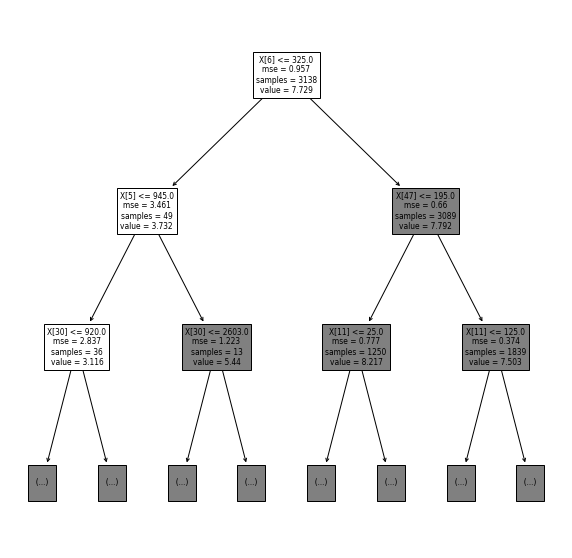

In [34]:


plt.figure(figsize = [10,10])
tree.plot_tree(dt, max_depth=2)
plt.show()

Decision tree model proves to be more effective than linerar model for this dataset. Predicts audit rates well.

### Random Forest - all tax

In [35]:
rf = RandomForestRegressor()
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [36]:
scores4 = cross_val_score(dt, X,y, cv = 10,  scoring= 'neg_root_mean_squared_error')
scores4, scores4.mean()

# RF regressor doesn't improve over simple decision tree

(array([-0.7035254 , -0.61156924, -0.48657277, -0.54400963, -0.55415829,
        -0.8964157 , -0.5267301 , -0.52726334, -0.81958025, -0.46666258]),
 -0.6136487295138854)

### Selected ratios

Next we see how well we can predict just on selected ratios, and see how features are correlated with outcomes

In [37]:
dftm.dropna(inplace= True)
dftm.shape

(3138, 146)

In [38]:
X2 = dftm.iloc[: , 131:136]
X2.head()

,volunteer_preparer_percentage,paid_preparer_percentage,wage_income_percentage,dividends_percentage,cap_gain_percentage
2,0.021285,0.457429,0.849750,0.114357,0.105175
3,0.018252,0.504295,0.775821,0.167490,0.169315
4,0.003128,0.687174,0.819604,0.099062,0.092805
5,0.006281,0.586683,0.866834,0.055276,0.055276
6,0.006812,0.638510,0.825613,0.084015,0.075386


In [39]:
lm = linear_model.LinearRegression()

In [40]:
lm.fit(X2, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [41]:
scores2 = cross_val_score(lm, X2, y, cv = 5, scoring= 'neg_root_mean_squared_error')
scores2

array([-0.93700235, -0.58589093, -1.01541658, -0.68158107, -1.07974774])

In [42]:
scores2.mean()
# using just selected ratios is predictive, but significantly less than model that uses all characteristics

-0.8599277323972541

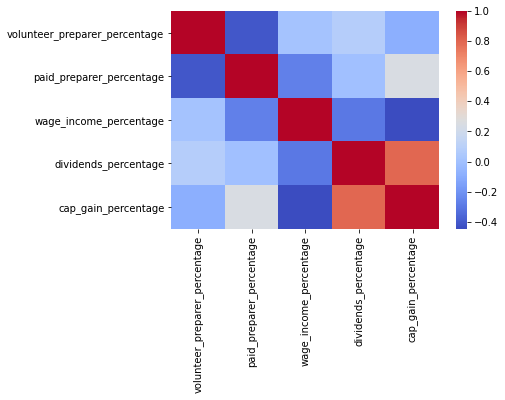

In [43]:
# Heatmap to show relationships between predictors and audit rates

sns.heatmap(X2.corr(), cmap = 'coolwarm')
plt.show()

# EDA 

## Unemployment

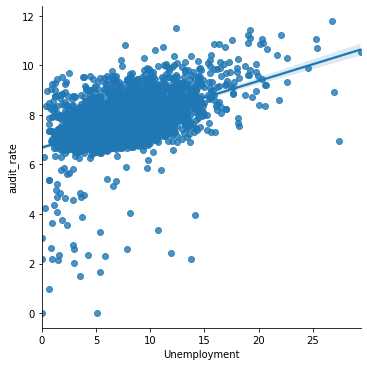

In [44]:
sns.lmplot(x ='Unemployment', y = 'audit_rate', data = dfmm)

## **Racial Analysis**

In [45]:
dfag = pd.read_csv('/content/audit-demographics-merged.csv')
dfag.head()

,fips,name,state,Number_of_returns,estimated_exams,audit_rate,audit_rate_trunk,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,Percentage_Male,Percentage_Citizen
0,1001,"Autauga County, Alabama",Alabama,95170.0,721.0,7.575917,7.575917,1001.0,Alabama,Autauga,55221.0,26745.0,28476.0,2.6,75.8,18.5,0.4,1.0,0.0,40725.0,51281.0,2391.0,24974.0,1080.0,12.9,18.6,33.2,17.0,24.2,8.6,17.1,87.5,8.8,0.1,0.5,1.3,1.8,26.5,23986.0,73.6,20.9,5.5,0.0,7.6,0.484327,0.737491
1,1003,"Baldwin County, Alabama",Alabama,362490.0,2833.0,7.815388,7.815388,1003.0,Alabama,Baldwin,195121.0,95314.0,99807.0,4.5,83.1,9.5,0.6,0.7,0.0,147695.0,50254.0,1263.0,27317.0,711.0,13.4,19.2,33.1,17.7,27.1,10.8,11.2,84.7,8.8,0.1,1.0,1.4,3.9,26.4,85953.0,81.5,12.3,5.8,0.4,7.5,0.488487,0.756941
2,1005,"Barbour County, Alabama",Alabama,39440.0,360.0,9.127789,9.127789,1005.0,Alabama,Barbour,26932.0,14497.0,12435.0,4.6,46.2,46.7,0.2,0.4,0.0,20714.0,32964.0,2973.0,16824.0,798.0,26.7,45.3,26.8,16.1,23.1,10.8,23.1,83.8,10.9,0.4,1.8,1.5,1.6,24.1,8597.0,71.8,20.8,7.3,0.1,17.6,0.538282,0.769122
3,1007,"Bibb County, Alabama",Alabama,31840.0,260.0,8.165829,8.165829,1007.0,Alabama,Bibb,22604.0,12073.0,10531.0,2.2,74.5,21.4,0.4,0.1,0.0,17495.0,38678.0,3995.0,18431.0,1618.0,16.8,27.9,21.5,17.9,17.8,19.0,23.7,83.2,13.5,0.5,0.6,1.5,0.7,28.8,8294.0,76.8,16.1,6.7,0.4,8.3,0.534109,0.773978
4,1009,"Blount County, Alabama",Alabama,87970.0,673.0,7.650335,7.650335,1009.0,Alabama,Blount,57710.0,28512.0,29198.0,8.6,87.9,1.5,0.3,0.1,0.0,42345.0,45813.0,3141.0,20532.0,708.0,16.7,27.2,28.5,14.1,23.9,13.5,19.9,84.9,11.2,0.4,0.9,0.4,2.3,34.9,22189.0,82.0,13.5,4.2,0.4,7.7,0.494056,0.733755


In [46]:
agg_race = dfag[['Hispanic', 'White','Black','Native', 'Asian', 'Pacific']]
agg_race.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3138 entries, 0 to 3137
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Hispanic  3138 non-null   float64
 1   White     3138 non-null   float64
 2   Black     3138 non-null   float64
 3   Native    3138 non-null   float64
 4   Asian     3138 non-null   float64
 5   Pacific   3138 non-null   float64
dtypes: float64(6)
memory usage: 147.2 KB


In [47]:
round(agg_race.mean(),2)

Hispanic     8.82
White       77.36
Black        8.89
Native       1.71
Asian        1.25
Pacific      0.07
dtype: float64

No handles with labels found to put in legend.


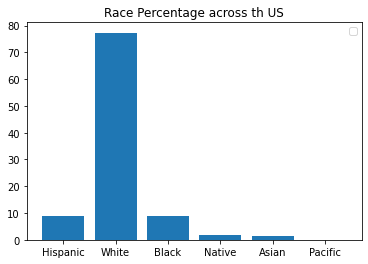

In [49]:
plt.bar( agg_race.columns, agg_race.mean())
plt.title('Race Percentage across th US')
plt.legend()
plt.show()

In [50]:
agg_race['balck_white_ratio'] = round(agg_race.Black / agg_race.White * 100, 2)
agg_race['audit_rate'] = dfag.audit_rate
agg_race.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Hispanic,White,Black,Native,Asian,Pacific,balck_white_ratio,audit_rate
0,2.6,75.8,18.5,0.4,1.0,0.0,24.41,7.575917
1,4.5,83.1,9.5,0.6,0.7,0.0,11.43,7.815388
2,4.6,46.2,46.7,0.2,0.4,0.0,101.08,9.127789
3,2.2,74.5,21.4,0.4,0.1,0.0,28.72,8.165829
4,8.6,87.9,1.5,0.3,0.1,0.0,1.71,7.650335


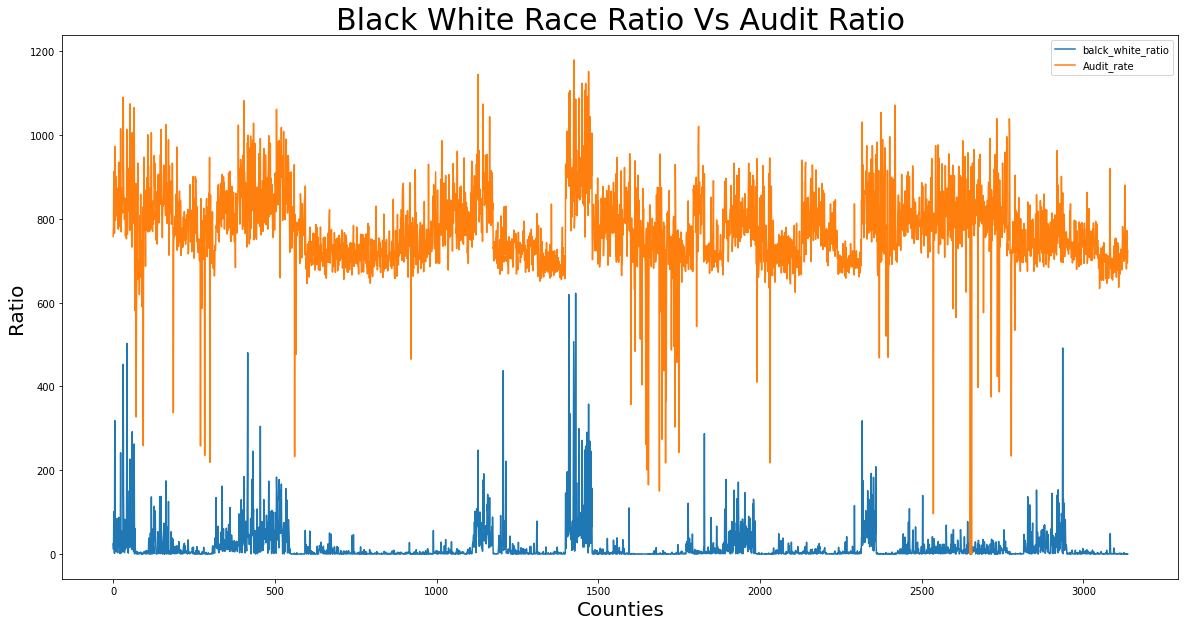

In [51]:
plt.figure(figsize=(20,10))

plt.plot(agg_race.balck_white_ratio, label='balck_white_ratio')
plt.plot(agg_race.audit_rate * 100, label='Audit_rate')

plt.xlabel('Counties', fontdict={'fontsize': 20})
plt.ylabel('Ratio', fontdict={'fontsize': 20})

plt.title('Black White Race Ratio Vs Audit Ratio', fontdict={'fontsize': 30})
plt.legend()

plt.show()